In [ ]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-c523c879-1dc3-7a73-a31f-2d8889c8d17f)


In [ ]:
# Get the data
!wget https://raw.githubusercontent.com/mlee687/CS470_AI-auto-trading/main/daily_single.csv

--2022-05-04 13:37:30--  https://raw.githubusercontent.com/mlee687/CS470_AI-auto-trading/main/daily_single.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50004 (49K) [text/plain]
Saving to: ‘daily_single.csv.1’

daily_single.csv.1  100%[===================>]  48.83K  --.-KB/s    in 0.01s   

2022-05-04 13:37:30 (4.84 MB/s) - ‘daily_single.csv.1’ saved [50004/50004]



In [ ]:
# Import with pandas 
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv("/content/daily_single.csv", parse_dates=["Timestamp"])
df.rename(columns = {"Daily_Close": "Price"}, inplace = True)
df['Timestamp'] = df['Timestamp'].dt.date
btc_df = df.set_index('Timestamp')
btc_df.head(), btc_df.tail()

(             Price
 Timestamp         
 2014-01-01  754.90
 2014-01-02  784.19
 2014-01-03  809.40
 2014-01-04  828.79
 2014-01-05  905.00,                Price
 Timestamp           
 2021-03-26  52734.30
 2021-03-27  54508.16
 2021-03-28  55871.93
 2021-03-29  57788.15
 2021-03-30  59069.29)

In [ ]:
len(btc_df)

2236

In [ ]:
btc_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2236 entries, 2014-01-01 to 2021-03-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   2236 non-null   float64
dtypes: float64(1)
memory usage: 34.9+ KB


In [ ]:
btc_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Price,2236.0,6692.873421,9291.712386,191.0,588.5375,4563.135,9107.615,60095.59


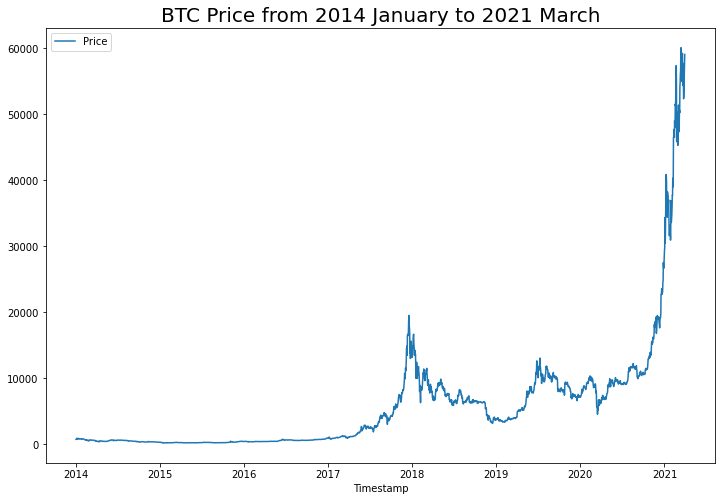

In [ ]:
import matplotlib.pyplot as plt
btc_df.plot(figsize = (12,8))
plt.title("BTC Price from 2014 January to 2021 March", fontsize=20);
# ';' is put at last to remove unnecessary text from being displayed

In [ ]:
btc_df.index.to_numpy()

array([datetime.date(2014, 1, 1), datetime.date(2014, 1, 2),
       datetime.date(2014, 1, 3), ..., datetime.date(2021, 3, 28),
       datetime.date(2021, 3, 29), datetime.date(2021, 3, 30)],
      dtype=object)

In [ ]:
# Makes arrays for each feature
timesteps = btc_df.index.to_numpy()
prices = btc_df["Price"].to_numpy()
boundary = int(0.8 * len(prices)) # 80% train, 20% test
X_train, y_train = timesteps[:boundary], prices[:boundary]
X_test, y_test = timesteps[boundary:], prices[boundary:]

len(X_train), len(X_test), len(y_train), len(y_test)

(1788, 448, 1788, 448)

In [ ]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None, xlabel='Timestamp', ylabel='Price'): 
  # for format, we can go with '.' or '-' [scatter or line] and start means offset
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

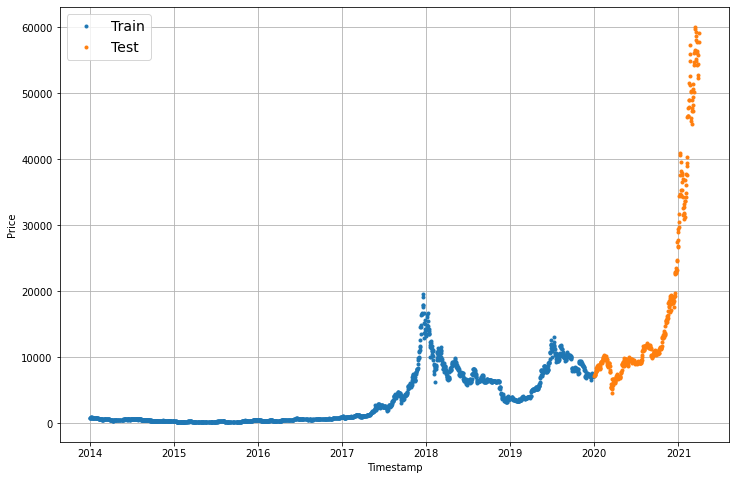

In [ ]:
plt.figure(figsize=(12,8)) # Creates a figure and adds the following plot to it
plot_time_series(X_train, y_train, label= "Train")
plot_time_series(X_test, y_test, label = "Test")
# It would be interesting to put start and end as the year

In [ ]:
# a = [1,2,3,4]
# a, a[:-1]

Naive baseline model:
$\hat{y}_{t} = y_{t-1}$

In [ ]:
naive_forecast = y_test[:-1] # Gets every value excluding the last value
# naive_forecast[-10:] != y_test[-10:]

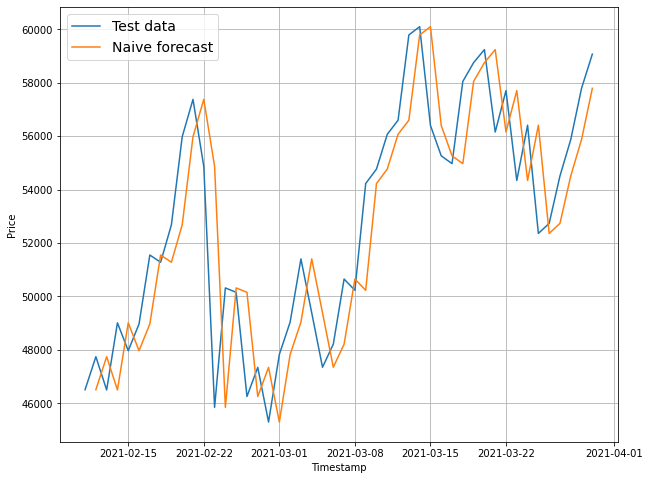

In [ ]:
# Comparing naive_forecast with the test data
plt.figure(figsize=(10, 8))
offset = 400
plot_time_series(timesteps=X_test, values=y_test, start = 400, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start = 400, format="-", label="Naive forecast");

In [ ]:
# Let's get TensorFlow! 
import tensorflow as tf

In [ ]:
def mase_(y_true, y_pred):
  # Assuming no seasonality and our crypto price data has no seasonality
  mae = tf.reduce_mean(tf.abs(y_true, y_pred))
  mae_naive = tf.reduce_mean(tf.abs(y_true[1:], naive_forecast)) # naive_forecast = y_true[:-1]
  return mae/mae_naive

In [ ]:
# mase(y_true=y_test[1:], y_pred= naive_forecast).numpy() #should be close to 1

In [ ]:
# type(y_test[0]),y_test[0].dtype
# Numpy is float64 datatype as default so we need to convert to float32 datatype while using tensorflow

In [ ]:
# returns error metrics in dictionary form:
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # better to use the numpy version of these too
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mase_(y_true, y_pred)
  
  return_dict =  {
                  "mae": mae.numpy(),
                  "mse": mse.numpy(),
                  "rmse": rmse.numpy(),
                  "mape": mape.numpy(),
                  "mase": mase.numpy()
                  }
  return return_dict

In [ ]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 571.1008,
 'mape': 2.7039125,
 'mase': 0.99867797,
 'mse': 1341613.6,
 'rmse': 1158.2805}

In [ ]:
tf.reduce_mean(y_test).numpy()

17809.185937500002

In [ ]:
# Windowing dataset to turn our data into supervised learning problem by giving labels
# Global variables are usually put with capital letters
# Using previous 7 days data to predict the price of 1 day
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# a=[1,2,3,4,5]
# a[:, :-1]
a = tf.expand_dims(tf.range(8)+1, axis=0)[:, :-1]
print(a)
tf.squeeze(a).numpy()

tf.Tensor([[1 2 3 4 5 6 7]], shape=(1, 7), dtype=int32)


array([1, 2, 3, 4, 5, 6, 7], dtype=int32)

In [ ]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


We need to do the above on our entire btc data. For doing it, using python for loops is good but it becomes very slow when using it in python for-loops so we are using numpy index.

In [ ]:
# make windows from numpy arrays
import numpy as np

def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    """
    returns 2D array of sequential windows of window size
    """
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  
    window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size+horizon-1)), axis=0).T # -1 to prevent window going off the last value

    # Here window_indexes gives the position of the value of respective indexes, so using x[window_indexes] puts the respective x values in the position
    # specified in the windoe_indexes. It only works with numpy arrays
    windowed_array = x[window_indexes]
    windows, labels = get_labelled_windows(windowed_array, horizon=HORIZON)
    return windows, labels

    # a = np.array([1,2,3,4])
    # x = np.array([10,11,12,13,14])
    # a, x, x[a]

In [ ]:
# Passing the whole dataset in the windows
full_windows, full_labels = make_windows(prices, WINDOW_SIZE, HORIZON)
len(full_windows), len(full_labels)

(2229, 2229)

In [ ]:
def make_train_test_splits(windows, labels, test_split = 0.2):
  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  # returns in the same order as skit-learn splitting function returns
  return train_windows, test_windows, train_labels, test_labels

In [ ]:
# Create a train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

In [ ]:
len(train_labels[:-HORIZON]), len(train_labels), len(train_labels[:-HORIZON-1]), len(y_train), len(y_train[WINDOW_SIZE:])

(1782, 1783, 1781, 1788, 1781)

In [ ]:
train_labels[:5], tf.squeeze(train_labels[:5]).numpy()

(array([[824.76],
        [852.61],
        [896.59],
        [844.05],
        [823.  ]]), array([824.76, 852.61, 896.59, 844.05, 823.  ]))

In [ ]:
# len(tf.keras.preprocessing.timeseries_dataset_from_array(data =prices, targets = None, sequence_length=7, sampling_rate=1, sequence_stride=1, shuffle=False))

In [ ]:
# Make the train/test splits
# Our approach is to window the data first and then make tests/train splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1783, 446, 1783, 446)

In [ ]:
train_windows

array([[ 754.9 ,  784.19,  809.4 , ...,  905.  ,  919.24,  785.  ],
       [ 784.19,  809.4 ,  828.79, ...,  919.24,  785.  ,  824.76],
       [ 809.4 ,  828.79,  905.  , ...,  785.  ,  824.76,  852.61],
       ...,
       [7208.69, 7181.73, 7133.65, ..., 7326.  , 7298.62, 7222.11],
       [7181.73, 7133.65, 7284.59, ..., 7298.62, 7222.11, 7171.68],
       [7133.65, 7284.59, 7326.  , ..., 7222.11, 7171.68, 7129.2 ]])

In [ ]:
# os is imported to save the model's best performance in google colab
import os
"""
  Since we are comparing different model's performance, it is better to compare each model's best performance with another model's best
  Model's performance is going to fluctuate epoch to epoch
  Create a function to implement a ModelCheckpoint callback with a specific filename 
"""

def create_model_checkpoint(model_name, save_path="models"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor='val_loss',
                                            verbose=0, # elsewise continously printout if saved or not
                                            save_best_only=True)

In [ ]:
""" 
  Model-1: Dense model (window=7, horizon=1)
  The values are chosen by doing experiments
"""

import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reprodicible results as possible
tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
  layers.Dense(128, activation='relu'),
  layers.Dense(HORIZON, activation='linear') # Same output as it was passed into it (similar to no activation)
], name='model_1_dense') # we can use it for our checkpoint function

# 2. Compile
model_1.compile(loss="mae",
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["mae", "mse"])

# 3. Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1, # it refers to how much information we want to print for our models
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # saves the best model



Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 1101.4684 - mae: 1101.4684 - mse: 3685982.0000 INFO:tensorflow:Assets written to: models/model_1_dense/assets


INFO:tensorflow:Assets written to: models/model_1_dense/assets


14/14 [==============================] - 1s 62ms/step - loss: 1101.4684 - mae: 1101.4684 - mse: 3685982.0000 - val_loss: 1823.5269 - val_mae: 1823.5269 - val_mse: 7447300.0000
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 364.8581 - mae: 364.8581 - mse: 455576.5938INFO:tensorflow:Assets written to: models/model_1_dense/assets


INFO:tensorflow:Assets written to: models/model_1_dense/assets


14/14 [==============================] - 1s 78ms/step - loss: 364.8581 - mae: 364.8581 - mse: 455576.5938 - val_loss: 1636.1923 - val_mae: 1636.1923 - val_mse: 6570600.0000
Epoch 3/100
13/14 [==========================>...] - ETA: 0s - loss: 256.2525 - mae: 256.2525 - mse: 252347.0156INFO:tensorflow:Assets written to: models/model_1_dense/assets


INFO:tensorflow:Assets written to: models/model_1_dense/assets


14/14 [==============================] - 1s 49ms/step - loss: 262.0759 - mae: 262.0759 - mse: 276247.6875 - val_loss: 910.5291 - val_mae: 910.5291 - val_mse: 2657821.0000
Epoch 4/100
14/14 [==============================] - ETA: 0s - loss: 229.8432 - mae: 229.8432 - mse: 223029.6406INFO:tensorflow:Assets written to: models/model_1_dense/assets


INFO:tensorflow:Assets written to: models/model_1_dense/assets


14/14 [==============================] - 1s 51ms/step - loss: 229.8432 - mae: 229.8432 - mse: 223029.6406 - val_loss: 871.9885 - val_mae: 871.9885 - val_mse: 2471781.5000
Epoch 5/100
14/14 [==============================] - 0s 8ms/step - loss: 213.3530 - mae: 213.3530 - mse: 196829.2500 - val_loss: 934.7549 - val_mae: 934.7549 - val_mse: 2760925.5000
Epoch 6/100
14/14 [==============================] - 0s 6ms/step - loss: 209.7133 - mae: 209.7133 - mse: 192899.4688 - val_loss: 966.5706 - val_mae: 966.5706 - val_mse: 2874033.7500
Epoch 7/100
14/14 [==============================] - 0s 7ms/step - loss: 206.8332 - mae: 206.8332 - mse: 191047.4844 - val_loss: 965.7445 - val_mae: 965.7445 - val_mse: 2848841.0000
Epoch 8/100
14/14 [==============================] - 0s 7ms/step - loss: 204.5820 - mae: 204.5820 - mse: 185115.7656 - val_loss: 903.3970 - val_mae: 903.3970 - val_mse: 2583670.7500
Epoch 9/100
14/14 [==============================] - ETA: 0s - loss: 198.6222 - mae: 198.6222 - mse: 

INFO:tensorflow:Assets written to: models/model_1_dense/assets


14/14 [==============================] - 1s 48ms/step - loss: 198.6222 - mae: 198.6222 - mse: 171793.7656 - val_loss: 835.3904 - val_mae: 835.3904 - val_mse: 2302950.2500
Epoch 10/100
 1/14 [=>............................] - ETA: 0s - loss: 158.1890 - mae: 158.1890 - mse: 109477.3125INFO:tensorflow:Assets written to: models/model_1_dense/assets


INFO:tensorflow:Assets written to: models/model_1_dense/assets


14/14 [==============================] - 1s 46ms/step - loss: 196.4742 - mae: 196.4742 - mse: 171026.3125 - val_loss: 802.7703 - val_mae: 802.7703 - val_mse: 2160369.2500
Epoch 11/100
14/14 [==============================] - ETA: 0s - loss: 193.1243 - mae: 193.1243 - mse: 166223.5000INFO:tensorflow:Assets written to: models/model_1_dense/assets


INFO:tensorflow:Assets written to: models/model_1_dense/assets


14/14 [==============================] - 1s 48ms/step - loss: 193.1243 - mae: 193.1243 - mse: 166223.5000 - val_loss: 794.5685 - val_mae: 794.5685 - val_mse: 2125808.0000
Epoch 12/100
14/14 [==============================] - 0s 7ms/step - loss: 186.3034 - mae: 186.3034 - mse: 156349.7344 - val_loss: 794.6605 - val_mae: 794.6605 - val_mse: 2118770.7500
Epoch 13/100
14/14 [==============================] - 0s 8ms/step - loss: 183.0405 - mae: 183.0405 - mse: 151985.6250 - val_loss: 799.4197 - val_mae: 799.4197 - val_mse: 2129493.5000
Epoch 14/100
14/14 [==============================] - ETA: 0s - loss: 179.3866 - mae: 179.3866 - mse: 146495.1562INFO:tensorflow:Assets written to: models/model_1_dense/assets


INFO:tensorflow:Assets written to: models/model_1_dense/assets


14/14 [==============================] - 1s 49ms/step - loss: 179.3866 - mae: 179.3866 - mse: 146495.1562 - val_loss: 738.9971 - val_mae: 738.9971 - val_mse: 1896003.7500
Epoch 15/100
13/14 [==========================>...] - ETA: 0s - loss: 182.0229 - mae: 182.0229 - mse: 141991.8125INFO:tensorflow:Assets written to: models/model_1_dense/assets


INFO:tensorflow:Assets written to: models/model_1_dense/assets


14/14 [==============================] - 1s 49ms/step - loss: 183.1302 - mae: 183.1302 - mse: 146731.1875 - val_loss: 729.9410 - val_mae: 729.9410 - val_mse: 1821407.0000
Epoch 16/100
14/14 [==============================] - 0s 8ms/step - loss: 178.4232 - mae: 178.4232 - mse: 139502.9688 - val_loss: 791.8325 - val_mae: 791.8325 - val_mse: 2067840.3750
Epoch 17/100
14/14 [==============================] - ETA: 0s - loss: 172.7325 - mae: 172.7325 - mse: 136047.9688INFO:tensorflow:Assets written to: models/model_1_dense/assets


INFO:tensorflow:Assets written to: models/model_1_dense/assets


14/14 [==============================] - 1s 48ms/step - loss: 172.7325 - mae: 172.7325 - mse: 136047.9688 - val_loss: 722.0017 - val_mae: 722.0017 - val_mse: 1833716.7500
Epoch 18/100
12/14 [========================>.....] - ETA: 0s - loss: 166.0195 - mae: 166.0195 - mse: 127820.5000INFO:tensorflow:Assets written to: models/model_1_dense/assets


INFO:tensorflow:Assets written to: models/model_1_dense/assets


14/14 [==============================] - 1s 49ms/step - loss: 165.2434 - mae: 165.2434 - mse: 128065.6719 - val_loss: 710.3107 - val_mae: 710.3107 - val_mse: 1786833.7500
Epoch 19/100
14/14 [==============================] - 0s 6ms/step - loss: 162.9875 - mae: 162.9875 - mse: 123605.6719 - val_loss: 721.5283 - val_mae: 721.5283 - val_mse: 1817951.7500
Epoch 20/100
 1/14 [=>............................] - ETA: 0s - loss: 159.0674 - mae: 159.0674 - mse: 100080.6719INFO:tensorflow:Assets written to: models/model_1_dense/assets


INFO:tensorflow:Assets written to: models/model_1_dense/assets


14/14 [==============================] - 1s 48ms/step - loss: 160.0695 - mae: 160.0695 - mse: 120657.0234 - val_loss: 685.6559 - val_mae: 685.6559 - val_mse: 1686122.7500
Epoch 21/100
14/14 [==============================] - 0s 7ms/step - loss: 158.1591 - mae: 158.1591 - mse: 118347.5781 - val_loss: 722.2169 - val_mae: 722.2169 - val_mse: 1807791.1250
Epoch 22/100
11/14 [======================>.......] - ETA: 0s - loss: 149.4980 - mae: 149.4980 - mse: 104409.4922INFO:tensorflow:Assets written to: models/model_1_dense/assets


INFO:tensorflow:Assets written to: models/model_1_dense/assets


14/14 [==============================] - 1s 49ms/step - loss: 158.7747 - mae: 158.7747 - mse: 116417.6875 - val_loss: 671.1667 - val_mae: 671.1667 - val_mse: 1611121.2500
Epoch 23/100
14/14 [==============================] - 0s 8ms/step - loss: 163.2771 - mae: 163.2771 - mse: 119600.4609 - val_loss: 733.8444 - val_mae: 733.8444 - val_mse: 1835300.2500
Epoch 24/100
14/14 [==============================] - 0s 7ms/step - loss: 152.4882 - mae: 152.4882 - mse: 109800.8203 - val_loss: 708.0053 - val_mae: 708.0053 - val_mse: 1747967.7500
Epoch 25/100
14/14 [==============================] - 0s 7ms/step - loss: 151.1617 - mae: 151.1617 - mse: 108886.1484 - val_loss: 682.2983 - val_mae: 682.2983 - val_mse: 1665091.5000
Epoch 26/100
12/14 [========================>.....] - ETA: 0s - loss: 147.5801 - mae: 147.5801 - mse: 106302.3359INFO:tensorflow:Assets written to: models/model_1_dense/assets


INFO:tensorflow:Assets written to: models/model_1_dense/assets


14/14 [==============================] - 1s 47ms/step - loss: 149.1958 - mae: 149.1958 - mse: 107721.7734 - val_loss: 655.1675 - val_mae: 655.1675 - val_mse: 1581801.6250
Epoch 27/100
14/14 [==============================] - ETA: 0s - loss: 148.8948 - mae: 148.8948 - mse: 105996.5000INFO:tensorflow:Assets written to: models/model_1_dense/assets


INFO:tensorflow:Assets written to: models/model_1_dense/assets


14/14 [==============================] - 1s 47ms/step - loss: 148.8948 - mae: 148.8948 - mse: 105996.5000 - val_loss: 640.7395 - val_mae: 640.7395 - val_mse: 1533247.1250
Epoch 28/100
14/14 [==============================] - 0s 7ms/step - loss: 148.3983 - mae: 148.3983 - mse: 104949.6953 - val_loss: 642.9067 - val_mae: 642.9067 - val_mse: 1544390.8750
Epoch 29/100
14/14 [==============================] - 0s 7ms/step - loss: 146.7692 - mae: 146.7692 - mse: 103940.5703 - val_loss: 654.2294 - val_mae: 654.2294 - val_mse: 1579109.7500
Epoch 30/100
14/14 [==============================] - 0s 7ms/step - loss: 145.6651 - mae: 145.6651 - mse: 101938.7266 - val_loss: 646.3860 - val_mae: 646.3860 - val_mse: 1556265.0000
Epoch 31/100
14/14 [==============================] - 0s 8ms/step - loss: 146.8964 - mae: 146.8964 - mse: 103603.4219 - val_loss: 791.1219 - val_mae: 791.1219 - val_mse: 1975462.3750
Epoch 32/100
14/14 [==============================] - ETA: 0s - loss: 151.2934 - mae: 151.2934 - 

INFO:tensorflow:Assets written to: models/model_1_dense/assets


14/14 [==============================] - 1s 48ms/step - loss: 151.2934 - mae: 151.2934 - mse: 103794.4688 - val_loss: 620.1498 - val_mae: 620.1498 - val_mse: 1478553.5000
Epoch 33/100
14/14 [==============================] - ETA: 0s - loss: 146.9766 - mae: 146.9766 - mse: 101281.1641INFO:tensorflow:Assets written to: models/model_1_dense/assets


INFO:tensorflow:Assets written to: models/model_1_dense/assets


14/14 [==============================] - 1s 49ms/step - loss: 146.9766 - mae: 146.9766 - mse: 101281.1641 - val_loss: 618.1885 - val_mae: 618.1885 - val_mse: 1474654.1250
Epoch 34/100
14/14 [==============================] - 0s 8ms/step - loss: 145.8924 - mae: 145.8924 - mse: 101268.8828 - val_loss: 654.1999 - val_mae: 654.1999 - val_mse: 1569257.0000
Epoch 35/100
13/14 [==========================>...] - ETA: 0s - loss: 140.6507 - mae: 140.6507 - mse: 97050.0000INFO:tensorflow:Assets written to: models/model_1_dense/assets


INFO:tensorflow:Assets written to: models/model_1_dense/assets


14/14 [==============================] - 1s 48ms/step - loss: 142.2126 - mae: 142.2126 - mse: 98747.2188 - val_loss: 616.8658 - val_mae: 616.8658 - val_mse: 1472621.8750
Epoch 36/100
14/14 [==============================] - 0s 7ms/step - loss: 142.6684 - mae: 142.6684 - mse: 98005.2969 - val_loss: 701.6244 - val_mae: 701.6244 - val_mse: 1691361.2500
Epoch 37/100
14/14 [==============================] - 0s 8ms/step - loss: 146.3780 - mae: 146.3780 - mse: 100083.1875 - val_loss: 672.4991 - val_mae: 672.4991 - val_mse: 1610113.0000
Epoch 38/100
14/14 [==============================] - ETA: 0s - loss: 146.1457 - mae: 146.1457 - mse: 102841.3516INFO:tensorflow:Assets written to: models/model_1_dense/assets


INFO:tensorflow:Assets written to: models/model_1_dense/assets


14/14 [==============================] - 1s 48ms/step - loss: 146.1457 - mae: 146.1457 - mse: 102841.3516 - val_loss: 608.4901 - val_mae: 608.4901 - val_mse: 1448470.0000
Epoch 39/100
14/14 [==============================] - 0s 7ms/step - loss: 141.7341 - mae: 141.7341 - mse: 97072.8672 - val_loss: 618.6324 - val_mae: 618.6324 - val_mse: 1475277.6250
Epoch 40/100
14/14 [==============================] - 0s 7ms/step - loss: 140.9656 - mae: 140.9656 - mse: 96063.1562 - val_loss: 725.8323 - val_mae: 725.8323 - val_mse: 1745317.0000
Epoch 41/100
14/14 [==============================] - 0s 8ms/step - loss: 146.9747 - mae: 146.9747 - mse: 100965.8984 - val_loss: 624.8782 - val_mae: 624.8782 - val_mse: 1487262.6250
Epoch 42/100
14/14 [==============================] - 0s 8ms/step - loss: 140.8617 - mae: 140.8617 - mse: 95995.0234 - val_loss: 608.8317 - val_mae: 608.8317 - val_mse: 1447788.2500
Epoch 43/100
14/14 [==============================] - ETA: 0s - loss: 140.8971 - mae: 140.8971 - mse

INFO:tensorflow:Assets written to: models/model_1_dense/assets


14/14 [==============================] - 1s 48ms/step - loss: 140.8971 - mae: 140.8971 - mse: 95812.2656 - val_loss: 604.2318 - val_mae: 604.2318 - val_mse: 1437878.5000
Epoch 44/100
14/14 [==============================] - 0s 7ms/step - loss: 140.6172 - mae: 140.6172 - mse: 94294.2578 - val_loss: 657.9724 - val_mae: 657.9724 - val_mse: 1561681.3750
Epoch 45/100
14/14 [==============================] - 0s 8ms/step - loss: 145.0954 - mae: 145.0954 - mse: 97884.3750 - val_loss: 611.8429 - val_mae: 611.8429 - val_mse: 1453006.8750
Epoch 46/100
14/14 [==============================] - 0s 7ms/step - loss: 137.3552 - mae: 137.3552 - mse: 93381.0078 - val_loss: 604.9779 - val_mae: 604.9779 - val_mse: 1436024.5000
Epoch 47/100
14/14 [==============================] - ETA: 0s - loss: 139.6044 - mae: 139.6044 - mse: 94610.8906INFO:tensorflow:Assets written to: models/model_1_dense/assets


INFO:tensorflow:Assets written to: models/model_1_dense/assets


14/14 [==============================] - 1s 46ms/step - loss: 139.6044 - mae: 139.6044 - mse: 94610.8906 - val_loss: 595.6401 - val_mae: 595.6401 - val_mse: 1415261.3750
Epoch 48/100
14/14 [==============================] - 0s 8ms/step - loss: 140.2585 - mae: 140.2585 - mse: 93798.6328 - val_loss: 627.5662 - val_mae: 627.5662 - val_mse: 1485448.7500
Epoch 49/100
14/14 [==============================] - 0s 8ms/step - loss: 138.3710 - mae: 138.3710 - mse: 91258.9141 - val_loss: 615.5536 - val_mae: 615.5536 - val_mse: 1457192.1250
Epoch 50/100
14/14 [==============================] - ETA: 0s - loss: 135.8162 - mae: 135.8162 - mse: 91383.0469 INFO:tensorflow:Assets written to: models/model_1_dense/assets


INFO:tensorflow:Assets written to: models/model_1_dense/assets


14/14 [==============================] - 1s 71ms/step - loss: 135.8162 - mae: 135.8162 - mse: 91383.0469 - val_loss: 591.3418 - val_mae: 591.3418 - val_mse: 1404130.0000
Epoch 51/100
14/14 [==============================] - 0s 8ms/step - loss: 136.1769 - mae: 136.1769 - mse: 92314.9453 - val_loss: 610.8250 - val_mae: 610.8250 - val_mse: 1443944.5000
Epoch 52/100
14/14 [==============================] - 0s 7ms/step - loss: 138.2684 - mae: 138.2684 - mse: 91524.1250 - val_loss: 595.0917 - val_mae: 595.0917 - val_mse: 1416519.0000
Epoch 53/100
14/14 [==============================] - ETA: 0s - loss: 138.2166 - mae: 138.2166 - mse: 93083.0078INFO:tensorflow:Assets written to: models/model_1_dense/assets


INFO:tensorflow:Assets written to: models/model_1_dense/assets


14/14 [==============================] - 1s 47ms/step - loss: 138.2166 - mae: 138.2166 - mse: 93083.0078 - val_loss: 590.3892 - val_mae: 590.3892 - val_mse: 1398299.0000
Epoch 54/100
14/14 [==============================] - 0s 8ms/step - loss: 141.2605 - mae: 141.2605 - mse: 94250.5703 - val_loss: 614.7706 - val_mae: 614.7706 - val_mse: 1463709.3750
Epoch 55/100
14/14 [==============================] - ETA: 0s - loss: 142.2205 - mae: 142.2205 - mse: 95579.9766 INFO:tensorflow:Assets written to: models/model_1_dense/assets


INFO:tensorflow:Assets written to: models/model_1_dense/assets


14/14 [==============================] - 1s 49ms/step - loss: 142.2205 - mae: 142.2205 - mse: 95579.9766 - val_loss: 589.0795 - val_mae: 589.0795 - val_mse: 1393960.1250
Epoch 56/100
14/14 [==============================] - 0s 8ms/step - loss: 135.8081 - mae: 135.8081 - mse: 92510.0781 - val_loss: 599.8378 - val_mae: 599.8378 - val_mse: 1415661.2500
Epoch 57/100
14/14 [==============================] - 0s 7ms/step - loss: 135.4442 - mae: 135.4442 - mse: 90530.5938 - val_loss: 635.9651 - val_mae: 635.9651 - val_mse: 1491043.0000
Epoch 58/100
14/14 [==============================] - 0s 7ms/step - loss: 134.5745 - mae: 134.5745 - mse: 90024.8359 - val_loss: 623.6661 - val_mae: 623.6661 - val_mse: 1465291.6250
Epoch 59/100
14/14 [==============================] - 0s 9ms/step - loss: 136.0547 - mae: 136.0547 - mse: 90179.8828 - val_loss: 632.2736 - val_mae: 632.2736 - val_mse: 1480801.2500
Epoch 60/100
11/14 [======================>.......] - ETA: 0s - loss: 129.9242 - mae: 129.9242 - mse: 

INFO:tensorflow:Assets written to: models/model_1_dense/assets


14/14 [==============================] - 1s 51ms/step - loss: 135.3951 - mae: 135.3951 - mse: 88947.6875 - val_loss: 584.3955 - val_mae: 584.3955 - val_mse: 1388934.3750
Epoch 61/100
14/14 [==============================] - 0s 7ms/step - loss: 139.0284 - mae: 139.0284 - mse: 93095.5859 - val_loss: 584.9880 - val_mae: 584.9880 - val_mse: 1391138.0000
Epoch 62/100
13/14 [==========================>...] - ETA: 0s - loss: 137.7252 - mae: 137.7252 - mse: 94320.5078 INFO:tensorflow:Assets written to: models/model_1_dense/assets


INFO:tensorflow:Assets written to: models/model_1_dense/assets


14/14 [==============================] - 1s 49ms/step - loss: 137.4404 - mae: 137.4404 - mse: 93706.3047 - val_loss: 581.4537 - val_mae: 581.4537 - val_mse: 1382257.3750
Epoch 63/100
14/14 [==============================] - 0s 8ms/step - loss: 132.4834 - mae: 132.4834 - mse: 88207.5078 - val_loss: 634.4350 - val_mae: 634.4350 - val_mse: 1481636.1250
Epoch 64/100
14/14 [==============================] - 0s 7ms/step - loss: 135.4466 - mae: 135.4466 - mse: 90275.6719 - val_loss: 713.3674 - val_mae: 713.3674 - val_mse: 1666185.1250
Epoch 65/100
14/14 [==============================] - 0s 7ms/step - loss: 136.5736 - mae: 136.5736 - mse: 87900.9844 - val_loss: 615.9663 - val_mae: 615.9663 - val_mse: 1441731.1250
Epoch 66/100
14/14 [==============================] - 0s 8ms/step - loss: 132.4134 - mae: 132.4134 - mse: 88252.6953 - val_loss: 609.4437 - val_mae: 609.4437 - val_mse: 1428662.5000
Epoch 67/100
13/14 [==========================>...] - ETA: 0s - loss: 136.2274 - mae: 136.2274 - mse: 

INFO:tensorflow:Assets written to: models/model_1_dense/assets


14/14 [==============================] - 1s 48ms/step - loss: 137.7155 - mae: 137.7155 - mse: 92258.5547 - val_loss: 581.0270 - val_mae: 581.0270 - val_mse: 1372685.8750
Epoch 68/100
14/14 [==============================] - ETA: 0s - loss: 132.8793 - mae: 132.8793 - mse: 87388.2500 INFO:tensorflow:Assets written to: models/model_1_dense/assets


INFO:tensorflow:Assets written to: models/model_1_dense/assets


14/14 [==============================] - 1s 50ms/step - loss: 132.8793 - mae: 132.8793 - mse: 87388.2500 - val_loss: 578.4183 - val_mae: 578.4183 - val_mse: 1369048.6250
Epoch 69/100
14/14 [==============================] - 0s 7ms/step - loss: 136.6080 - mae: 136.6080 - mse: 91667.2188 - val_loss: 623.0688 - val_mae: 623.0688 - val_mse: 1455172.2500
Epoch 70/100
13/14 [==========================>...] - ETA: 0s - loss: 131.5812 - mae: 131.5812 - mse: 86518.8438INFO:tensorflow:Assets written to: models/model_1_dense/assets


INFO:tensorflow:Assets written to: models/model_1_dense/assets


14/14 [==============================] - 1s 48ms/step - loss: 132.1132 - mae: 132.1132 - mse: 86706.4609 - val_loss: 575.5281 - val_mae: 575.5281 - val_mse: 1365532.3750
Epoch 71/100
14/14 [==============================] - 0s 8ms/step - loss: 136.5641 - mae: 136.5641 - mse: 90064.2969 - val_loss: 592.4233 - val_mae: 592.4233 - val_mse: 1405433.3750
Epoch 72/100
14/14 [==============================] - ETA: 0s - loss: 144.6254 - mae: 144.6254 - mse: 96750.8672 INFO:tensorflow:Assets written to: models/model_1_dense/assets


INFO:tensorflow:Assets written to: models/model_1_dense/assets


14/14 [==============================] - 1s 48ms/step - loss: 144.6254 - mae: 144.6254 - mse: 96750.8672 - val_loss: 573.7808 - val_mae: 573.7808 - val_mse: 1360967.1250
Epoch 73/100
14/14 [==============================] - 0s 8ms/step - loss: 139.3172 - mae: 139.3172 - mse: 94009.5938 - val_loss: 582.0944 - val_mae: 582.0944 - val_mse: 1371706.7500
Epoch 74/100
14/14 [==============================] - 0s 8ms/step - loss: 138.3585 - mae: 138.3585 - mse: 90898.0391 - val_loss: 627.6675 - val_mae: 627.6675 - val_mse: 1460331.5000
Epoch 75/100
14/14 [==============================] - 0s 6ms/step - loss: 134.9120 - mae: 134.9120 - mse: 90793.5938 - val_loss: 595.4852 - val_mae: 595.4852 - val_mse: 1395538.3750
Epoch 76/100
14/14 [==============================] - ETA: 0s - loss: 131.5670 - mae: 131.5670 - mse: 87004.7031INFO:tensorflow:Assets written to: models/model_1_dense/assets


INFO:tensorflow:Assets written to: models/model_1_dense/assets


14/14 [==============================] - 1s 48ms/step - loss: 131.5670 - mae: 131.5670 - mse: 87004.7031 - val_loss: 571.1689 - val_mae: 571.1689 - val_mse: 1355656.6250
Epoch 77/100
14/14 [==============================] - 0s 8ms/step - loss: 137.9530 - mae: 137.9530 - mse: 91226.2734 - val_loss: 572.2129 - val_mae: 572.2129 - val_mse: 1353040.3750
Epoch 78/100
14/14 [==============================] - 0s 8ms/step - loss: 132.8780 - mae: 132.8780 - mse: 87069.3828 - val_loss: 614.7012 - val_mae: 614.7012 - val_mse: 1431259.2500
Epoch 79/100
14/14 [==============================] - 0s 7ms/step - loss: 139.8954 - mae: 139.8954 - mse: 91336.5938 - val_loss: 572.6580 - val_mae: 572.6580 - val_mse: 1359021.6250
Epoch 80/100
14/14 [==============================] - 0s 8ms/step - loss: 136.1005 - mae: 136.1005 - mse: 88409.0703 - val_loss: 574.0020 - val_mae: 574.0020 - val_mse: 1365526.5000
Epoch 81/100
14/14 [==============================] - 0s 7ms/step - loss: 131.8882 - mae: 131.8882 - m

INFO:tensorflow:Assets written to: models/model_1_dense/assets


14/14 [==============================] - 1s 48ms/step - loss: 136.4020 - mae: 136.4020 - mse: 89194.8047 - val_loss: 565.7719 - val_mae: 565.7719 - val_mse: 1340969.0000
Epoch 92/100
14/14 [==============================] - 0s 7ms/step - loss: 130.1774 - mae: 130.1774 - mse: 85566.7188 - val_loss: 594.9121 - val_mae: 594.9121 - val_mse: 1388158.0000
Epoch 93/100
14/14 [==============================] - 0s 7ms/step - loss: 130.6894 - mae: 130.6894 - mse: 85181.8047 - val_loss: 659.2480 - val_mae: 659.2480 - val_mse: 1520064.2500
Epoch 94/100
14/14 [==============================] - 0s 7ms/step - loss: 138.7995 - mae: 138.7995 - mse: 89496.2031 - val_loss: 568.5506 - val_mae: 568.5506 - val_mse: 1350210.0000
Epoch 95/100
14/14 [==============================] - 0s 7ms/step - loss: 134.8216 - mae: 134.8216 - mse: 89024.4844 - val_loss: 571.6528 - val_mae: 571.6528 - val_mse: 1357251.6250
Epoch 96/100
14/14 [==============================] - 0s 7ms/step - loss: 132.5165 - mae: 132.5165 - m

INFO:tensorflow:Assets written to: models/model_1_dense/assets


14/14 [==============================] - 1s 48ms/step - loss: 135.5739 - mae: 135.5739 - mse: 86971.9375 - val_loss: 565.1275 - val_mae: 565.1275 - val_mse: 1337065.0000
Epoch 98/100
14/14 [==============================] - 0s 7ms/step - loss: 130.7368 - mae: 130.7368 - mse: 85185.1016 - val_loss: 575.0678 - val_mae: 575.0678 - val_mse: 1363774.7500
Epoch 99/100
 1/14 [=>............................] - ETA: 0s - loss: 130.8216 - mae: 130.8216 - mse: 96000.4297INFO:tensorflow:Assets written to: models/model_1_dense/assets


INFO:tensorflow:Assets written to: models/model_1_dense/assets


14/14 [==============================] - 1s 48ms/step - loss: 131.0261 - mae: 131.0261 - mse: 83135.2656 - val_loss: 563.8820 - val_mae: 563.8820 - val_mse: 1339608.0000
Epoch 100/100
14/14 [==============================] - 0s 8ms/step - loss: 129.6634 - mae: 129.6634 - mse: 82576.5078 - val_loss: 571.8762 - val_mae: 571.8762 - val_mse: 1358417.1250


In [ ]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)
# This is not the model's best performance, it is the last epoch's performance

14/14 [==============================] - 0s 3ms/step - loss: 571.8762 - mae: 571.8762 - mse: 1358417.2500


[571.8761596679688, 571.8761596679688, 1358417.25]

In [ ]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("models/model_1_dense")
model_1.evaluate(test_windows, test_labels)

14/14 [==============================] - 0s 3ms/step - loss: 563.8820 - mae: 563.8820 - mse: 1339608.0000


[563.8819580078125, 563.8819580078125, 1339608.0]

Ateps for making a forecast on the test dataset:
* Take in a train model
* Take in some input data (same kind of data the model was trained on)
* Passes the input data to the model's `predict()` method
* Returns the predictions

In [ ]:
## After evaluating the model, lets forecast using the model (it is pseudo forecast)
def make_prediction(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # Squeezing is needed because we are returning 1D array of predictions

In [ ]:
# Make predictions using model_1 on the test dataset and evaluate it on test data
# Because of the model1 checkpoint, we are getting the predictions from the best performing model
model_1_prediction = make_prediction(model_1, test_windows)
len(model_1_prediction), model_1_prediction[:10]

(446, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([7325.8184, 7375.141 , 7473.6396, 7583.598 , 7968.247 , 8359.744 ,
        8034.2114, 7894.658 , 8068.199 , 8165.1646], dtype=float32)>)

The most common errors in machine learning is the input and output size

In [ ]:
test_labels.shape, model_1_prediction.shape, tf.squeeze(test_labels).shape

((446, 1), TensorShape([446]), TensorShape([446]))

In [ ]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_1_prediction)
model_1_results

{'mae': 563.88196,
 'mape': 2.7862256,
 'mase': 0.99867654,
 'mse': 1339608.1,
 'rmse': 1157.4144}

In [ ]:
naive_results

{'mae': 571.1008,
 'mape': 2.7039125,
 'mase': 0.99867797,
 'mse': 1341613.6,
 'rmse': 1158.2805}

In [ ]:
a = [1,2,3,4]
a[-2:]

[3, 4]

In [ ]:
len(X_test), len(test_windows)

(448, 446)

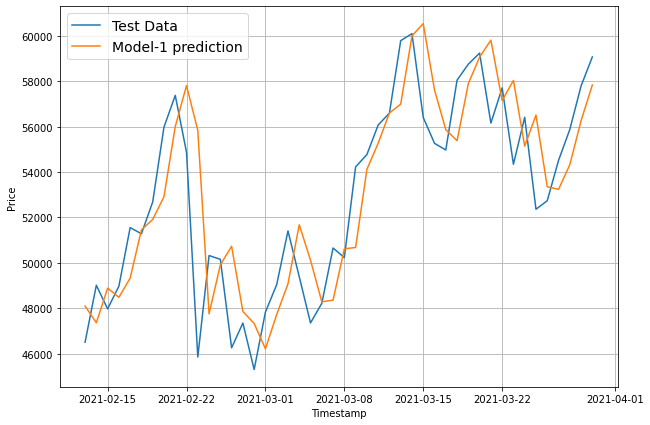

In [ ]:
# Plotting model-1 predictions
plt.figure(figsize=(10,7))
offset=400
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label='Test Data', format="-")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_prediction, start=offset, label="Model-1 prediction", format='-')

In [ ]:
# [:,0] means get every rows and get the zeroth dimenstion

In [ ]:
# Autoregressive data is the reason for our prediction coming after the actual value

### We can make a large horizon predictions (like a week prediction) and later use either mean metric or any other to make a one prediciton

In [ ]:
# Instead of prediction the exact prediction point, we can predict the prediction direction or prediction intervals like 99% prediction interval

In [ ]:
## Model-2: Dense (Windows:30, Horizon:1)
HORIZON=1
WINDOW_SIZE=30

In [ ]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2206, 2206)

In [ ]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1764, 442, 1764, 442)

In [ ]:
train_windows[:3]

array([[754.9 , 784.19, 809.4 , 828.79, 905.  , 919.24, 785.  , 824.76,
        852.61, 896.59, 844.05, 823.  , 841.14, 814.4 , 797.2 , 842.07,
        826.02, 812.  , 780.  , 806.8 , 751.95, 788.  , 794.21, 799.99,
        803.  , 814.99, 782.33, 763.99, 705.01, 680.49],
       [784.19, 809.4 , 828.79, 905.  , 919.24, 785.  , 824.76, 852.61,
        896.59, 844.05, 823.  , 841.14, 814.4 , 797.2 , 842.07, 826.02,
        812.  , 780.  , 806.8 , 751.95, 788.  , 794.21, 799.99, 803.  ,
        814.99, 782.33, 763.99, 705.01, 680.49, 687.81],
       [809.4 , 828.79, 905.  , 919.24, 785.  , 824.76, 852.61, 896.59,
        844.05, 823.  , 841.14, 814.4 , 797.2 , 842.07, 826.02, 812.  ,
        780.  , 806.8 , 751.95, 788.  , 794.21, 799.99, 803.  , 814.99,
        782.33, 763.99, 705.01, 680.49, 687.81, 675.1 ]])

In [ ]:
len(prices)

2236

In [ ]:
tf.random.set_seed(42)
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="relu")
], name="model_2_dense")

model_2.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

Epoch 1/100
 1/14 [=>............................] - ETA: 5s - loss: 4251.6206INFO:tensorflow:Assets written to: models/model_2_dense/assets


INFO:tensorflow:Assets written to: models/model_2_dense/assets


14/14 [==============================] - 1s 56ms/step - loss: 1372.0996 - val_loss: 5363.8164
Epoch 2/100
 1/14 [=>............................] - ETA: 0s - loss: 897.0695INFO:tensorflow:Assets written to: models/model_2_dense/assets


INFO:tensorflow:Assets written to: models/model_2_dense/assets


14/14 [==============================] - 1s 43ms/step - loss: 606.1738 - val_loss: 3543.5481
Epoch 3/100
 1/14 [=>............................] - ETA: 0s - loss: 654.4217INFO:tensorflow:Assets written to: models/model_2_dense/assets


INFO:tensorflow:Assets written to: models/model_2_dense/assets


14/14 [==============================] - 1s 44ms/step - loss: 472.0771 - val_loss: 1521.0830
Epoch 4/100
 1/14 [=>............................] - ETA: 0s - loss: 266.4693INFO:tensorflow:Assets written to: models/model_2_dense/assets


INFO:tensorflow:Assets written to: models/model_2_dense/assets


14/14 [==============================] - 1s 46ms/step - loss: 311.1849 - val_loss: 1250.7550
Epoch 5/100
 1/14 [=>............................] - ETA: 0s - loss: 343.7678INFO:tensorflow:Assets written to: models/model_2_dense/assets


INFO:tensorflow:Assets written to: models/model_2_dense/assets


14/14 [==============================] - 1s 44ms/step - loss: 254.1111 - val_loss: 1091.2778
Epoch 6/100
 1/14 [=>............................] - ETA: 0s - loss: 221.1263INFO:tensorflow:Assets written to: models/model_2_dense/assets


INFO:tensorflow:Assets written to: models/model_2_dense/assets


14/14 [==============================] - 1s 71ms/step - loss: 237.3476 - val_loss: 1027.5642
Epoch 7/100
 1/14 [=>............................] - ETA: 0s - loss: 196.9706INFO:tensorflow:Assets written to: models/model_2_dense/assets


INFO:tensorflow:Assets written to: models/model_2_dense/assets


14/14 [==============================] - 1s 46ms/step - loss: 229.6923 - val_loss: 941.8699
Epoch 8/100
14/14 [==============================] - 0s 6ms/step - loss: 233.8298 - val_loss: 1318.6437
Epoch 9/100
14/14 [==============================] - 0s 6ms/step - loss: 243.0570 - val_loss: 1126.8372
Epoch 10/100
 1/14 [=>............................] - ETA: 0s - loss: 214.6198INFO:tensorflow:Assets written to: models/model_2_dense/assets


INFO:tensorflow:Assets written to: models/model_2_dense/assets


14/14 [==============================] - 1s 46ms/step - loss: 242.1604 - val_loss: 868.5416
Epoch 11/100
14/14 [==============================] - 0s 6ms/step - loss: 214.2319 - val_loss: 959.4741
Epoch 12/100
 1/14 [=>............................] - ETA: 0s - loss: 213.0576INFO:tensorflow:Assets written to: models/model_2_dense/assets


INFO:tensorflow:Assets written to: models/model_2_dense/assets


14/14 [==============================] - 1s 46ms/step - loss: 206.8291 - val_loss: 842.5629
Epoch 13/100
 1/14 [=>............................] - ETA: 0s - loss: 233.8888INFO:tensorflow:Assets written to: models/model_2_dense/assets


INFO:tensorflow:Assets written to: models/model_2_dense/assets


14/14 [==============================] - 1s 48ms/step - loss: 197.7834 - val_loss: 827.8760
Epoch 14/100
14/14 [==============================] - 0s 7ms/step - loss: 193.5604 - val_loss: 880.5116
Epoch 15/100
 1/14 [=>............................] - ETA: 0s - loss: 210.1398INFO:tensorflow:Assets written to: models/model_2_dense/assets


INFO:tensorflow:Assets written to: models/model_2_dense/assets


14/14 [==============================] - 1s 48ms/step - loss: 194.7650 - val_loss: 795.9081
Epoch 16/100
14/14 [==============================] - 0s 7ms/step - loss: 195.5183 - val_loss: 868.3561
Epoch 17/100
14/14 [==============================] - 0s 7ms/step - loss: 192.2065 - val_loss: 800.4167
Epoch 18/100
 1/14 [=>............................] - ETA: 0s - loss: 231.1131INFO:tensorflow:Assets written to: models/model_2_dense/assets


INFO:tensorflow:Assets written to: models/model_2_dense/assets


14/14 [==============================] - 1s 44ms/step - loss: 188.8398 - val_loss: 781.9801
Epoch 19/100
 1/14 [=>............................] - ETA: 0s - loss: 172.8582INFO:tensorflow:Assets written to: models/model_2_dense/assets


INFO:tensorflow:Assets written to: models/model_2_dense/assets


14/14 [==============================] - 1s 49ms/step - loss: 195.3169 - val_loss: 779.8920
Epoch 20/100
 1/14 [=>............................] - ETA: 0s - loss: 205.2815INFO:tensorflow:Assets written to: models/model_2_dense/assets


INFO:tensorflow:Assets written to: models/model_2_dense/assets


14/14 [==============================] - 1s 46ms/step - loss: 179.9776 - val_loss: 762.8174
Epoch 21/100
14/14 [==============================] - 0s 7ms/step - loss: 181.0282 - val_loss: 777.2593
Epoch 22/100
 1/14 [=>............................] - ETA: 0s - loss: 184.4480INFO:tensorflow:Assets written to: models/model_2_dense/assets


INFO:tensorflow:Assets written to: models/model_2_dense/assets


14/14 [==============================] - 1s 45ms/step - loss: 182.1305 - val_loss: 751.0550
Epoch 23/100
 1/14 [=>............................] - ETA: 0s - loss: 182.5091INFO:tensorflow:Assets written to: models/model_2_dense/assets


INFO:tensorflow:Assets written to: models/model_2_dense/assets


14/14 [==============================] - 1s 45ms/step - loss: 172.5988 - val_loss: 747.6547
Epoch 24/100
14/14 [==============================] - 0s 7ms/step - loss: 177.1282 - val_loss: 762.1643
Epoch 25/100
14/14 [==============================] - 0s 6ms/step - loss: 174.5819 - val_loss: 815.0490
Epoch 26/100
14/14 [==============================] - 0s 7ms/step - loss: 185.1629 - val_loss: 922.8735
Epoch 27/100
14/14 [==============================] - 0s 6ms/step - loss: 177.9686 - val_loss: 822.9124
Epoch 28/100
14/14 [==============================] - 0s 6ms/step - loss: 183.6470 - val_loss: 788.9307
Epoch 29/100
14/14 [==============================] - 0s 6ms/step - loss: 175.5605 - val_loss: 748.1068
Epoch 30/100
 1/14 [=>............................] - ETA: 0s - loss: 159.2082INFO:tensorflow:Assets written to: models/model_2_dense/assets


INFO:tensorflow:Assets written to: models/model_2_dense/assets


14/14 [==============================] - 1s 46ms/step - loss: 167.1365 - val_loss: 725.1519
Epoch 31/100
14/14 [==============================] - 0s 6ms/step - loss: 185.5827 - val_loss: 944.4926
Epoch 32/100
14/14 [==============================] - 0s 6ms/step - loss: 188.8088 - val_loss: 736.0702
Epoch 33/100
 1/14 [=>............................] - ETA: 0s - loss: 174.9070INFO:tensorflow:Assets written to: models/model_2_dense/assets


INFO:tensorflow:Assets written to: models/model_2_dense/assets


14/14 [==============================] - 1s 45ms/step - loss: 170.7866 - val_loss: 704.1850
Epoch 34/100
14/14 [==============================] - 0s 6ms/step - loss: 167.6221 - val_loss: 767.9929
Epoch 35/100
 1/14 [=>............................] - ETA: 0s - loss: 127.4080INFO:tensorflow:Assets written to: models/model_2_dense/assets


INFO:tensorflow:Assets written to: models/model_2_dense/assets


14/14 [==============================] - 1s 44ms/step - loss: 162.1399 - val_loss: 704.1454
Epoch 36/100
14/14 [==============================] - 0s 7ms/step - loss: 196.6371 - val_loss: 712.7943
Epoch 37/100
 1/14 [=>............................] - ETA: 0s - loss: 181.9679INFO:tensorflow:Assets written to: models/model_2_dense/assets


INFO:tensorflow:Assets written to: models/model_2_dense/assets


14/14 [==============================] - 1s 44ms/step - loss: 163.3848 - val_loss: 692.4246
Epoch 38/100
14/14 [==============================] - 0s 7ms/step - loss: 167.1173 - val_loss: 697.5242
Epoch 39/100
14/14 [==============================] - 0s 6ms/step - loss: 162.2582 - val_loss: 831.6859
Epoch 40/100
14/14 [==============================] - 0s 6ms/step - loss: 170.4290 - val_loss: 775.2582
Epoch 41/100
14/14 [==============================] - 0s 6ms/step - loss: 178.0286 - val_loss: 693.6858
Epoch 42/100
14/14 [==============================] - 0s 7ms/step - loss: 158.1630 - val_loss: 766.2222
Epoch 43/100
14/14 [==============================] - 0s 6ms/step - loss: 169.3176 - val_loss: 709.9193
Epoch 44/100
14/14 [==============================] - 0s 7ms/step - loss: 158.7215 - val_loss: 785.0952
Epoch 45/100
 1/14 [=>............................] - ETA: 0s - loss: 149.6550INFO:tensorflow:Assets written to: models/model_2_dense/assets


INFO:tensorflow:Assets written to: models/model_2_dense/assets


14/14 [==============================] - 1s 43ms/step - loss: 173.5923 - val_loss: 691.3474
Epoch 46/100
 1/14 [=>............................] - ETA: 0s - loss: 167.9112INFO:tensorflow:Assets written to: models/model_2_dense/assets


INFO:tensorflow:Assets written to: models/model_2_dense/assets


14/14 [==============================] - 1s 45ms/step - loss: 165.3671 - val_loss: 668.8582
Epoch 47/100
 1/14 [=>............................] - ETA: 0s - loss: 157.2963INFO:tensorflow:Assets written to: models/model_2_dense/assets


INFO:tensorflow:Assets written to: models/model_2_dense/assets


14/14 [==============================] - 1s 42ms/step - loss: 153.9284 - val_loss: 666.6786
Epoch 48/100
14/14 [==============================] - 0s 7ms/step - loss: 151.8965 - val_loss: 666.7917
Epoch 49/100
14/14 [==============================] - 0s 7ms/step - loss: 159.5269 - val_loss: 679.0476
Epoch 50/100
14/14 [==============================] - 0s 6ms/step - loss: 152.6160 - val_loss: 717.6262
Epoch 51/100
14/14 [==============================] - 0s 5ms/step - loss: 161.3149 - val_loss: 882.5731
Epoch 52/100
14/14 [==============================] - 0s 7ms/step - loss: 179.0446 - val_loss: 706.7265
Epoch 53/100
14/14 [==============================] - 0s 6ms/step - loss: 149.7749 - val_loss: 693.0235
Epoch 54/100
 1/14 [=>............................] - ETA: 0s - loss: 135.2604INFO:tensorflow:Assets written to: models/model_2_dense/assets


INFO:tensorflow:Assets written to: models/model_2_dense/assets


14/14 [==============================] - 1s 43ms/step - loss: 150.4680 - val_loss: 651.1354
Epoch 55/100
14/14 [==============================] - 0s 7ms/step - loss: 163.9126 - val_loss: 961.8381
Epoch 56/100
 1/14 [=>............................] - ETA: 0s - loss: 228.1972INFO:tensorflow:Assets written to: models/model_2_dense/assets


INFO:tensorflow:Assets written to: models/model_2_dense/assets


14/14 [==============================] - 1s 43ms/step - loss: 179.6303 - val_loss: 649.1189
Epoch 57/100
14/14 [==============================] - 0s 6ms/step - loss: 158.5018 - val_loss: 673.2388
Epoch 58/100
14/14 [==============================] - 0s 7ms/step - loss: 156.2246 - val_loss: 668.3504
Epoch 59/100
14/14 [==============================] - ETA: 0s - loss: 157.1393INFO:tensorflow:Assets written to: models/model_2_dense/assets


INFO:tensorflow:Assets written to: models/model_2_dense/assets


14/14 [==============================] - 1s 71ms/step - loss: 157.1393 - val_loss: 638.1348
Epoch 60/100
 1/14 [=>............................] - ETA: 0s - loss: 136.9111INFO:tensorflow:Assets written to: models/model_2_dense/assets


INFO:tensorflow:Assets written to: models/model_2_dense/assets


14/14 [==============================] - 1s 47ms/step - loss: 165.5027 - val_loss: 637.2512
Epoch 61/100
14/14 [==============================] - 0s 6ms/step - loss: 150.3960 - val_loss: 690.5607
Epoch 62/100
14/14 [==============================] - 0s 7ms/step - loss: 171.5056 - val_loss: 650.1177
Epoch 63/100
14/14 [==============================] - 0s 6ms/step - loss: 152.6674 - val_loss: 638.6284
Epoch 64/100
14/14 [==============================] - 0s 6ms/step - loss: 145.7584 - val_loss: 651.7063
Epoch 65/100
14/14 [==============================] - 0s 6ms/step - loss: 154.8430 - val_loss: 775.8221
Epoch 66/100
14/14 [==============================] - 0s 7ms/step - loss: 168.4166 - val_loss: 755.4880
Epoch 67/100
14/14 [==============================] - 0s 7ms/step - loss: 145.4458 - val_loss: 690.6177
Epoch 68/100
 1/14 [=>............................] - ETA: 0s - loss: 183.7149INFO:tensorflow:Assets written to: models/model_2_dense/assets


INFO:tensorflow:Assets written to: models/model_2_dense/assets


14/14 [==============================] - 1s 45ms/step - loss: 163.5427 - val_loss: 626.4257
Epoch 69/100
14/14 [==============================] - 0s 6ms/step - loss: 169.1395 - val_loss: 820.4280
Epoch 70/100
14/14 [==============================] - 0s 6ms/step - loss: 162.1384 - val_loss: 670.5687
Epoch 71/100
14/14 [==============================] - 0s 8ms/step - loss: 161.3476 - val_loss: 901.2624
Epoch 72/100
14/14 [==============================] - 0s 7ms/step - loss: 198.9752 - val_loss: 659.7496
Epoch 73/100
14/14 [==============================] - 0s 6ms/step - loss: 146.3261 - val_loss: 629.3884
Epoch 74/100
14/14 [==============================] - 0s 6ms/step - loss: 150.2139 - val_loss: 854.9048
Epoch 75/100
14/14 [==============================] - 0s 6ms/step - loss: 172.9810 - val_loss: 762.2597
Epoch 76/100
14/14 [==============================] - 0s 6ms/step - loss: 167.1365 - val_loss: 799.0766
Epoch 77/100
 1/14 [=>............................] - ETA: 0s - loss: 218.88

INFO:tensorflow:Assets written to: models/model_2_dense/assets


14/14 [==============================] - 1s 45ms/step - loss: 155.2555 - val_loss: 617.2737
Epoch 78/100
14/14 [==============================] - 0s 6ms/step - loss: 144.1714 - val_loss: 685.4675
Epoch 79/100
14/14 [==============================] - 0s 6ms/step - loss: 146.7644 - val_loss: 619.8881
Epoch 80/100
14/14 [==============================] - 0s 6ms/step - loss: 150.7998 - val_loss: 825.6550
Epoch 81/100
14/14 [==============================] - 0s 6ms/step - loss: 163.7673 - val_loss: 649.8982
Epoch 82/100
 1/14 [=>............................] - ETA: 0s - loss: 96.0567INFO:tensorflow:Assets written to: models/model_2_dense/assets


INFO:tensorflow:Assets written to: models/model_2_dense/assets


14/14 [==============================] - 1s 45ms/step - loss: 141.1362 - val_loss: 613.8935
Epoch 83/100
14/14 [==============================] - 0s 6ms/step - loss: 140.1337 - val_loss: 622.0269
Epoch 84/100
14/14 [==============================] - 0s 7ms/step - loss: 147.6888 - val_loss: 747.1668
Epoch 85/100
14/14 [==============================] - 0s 7ms/step - loss: 148.8384 - val_loss: 614.3834
Epoch 86/100
 1/14 [=>............................] - ETA: 0s - loss: 117.5621INFO:tensorflow:Assets written to: models/model_2_dense/assets


INFO:tensorflow:Assets written to: models/model_2_dense/assets


14/14 [==============================] - 1s 46ms/step - loss: 148.6183 - val_loss: 611.5448
Epoch 87/100
14/14 [==============================] - 0s 7ms/step - loss: 149.7943 - val_loss: 627.4006
Epoch 88/100
14/14 [==============================] - 0s 6ms/step - loss: 143.3698 - val_loss: 700.4344
Epoch 89/100
14/14 [==============================] - 0s 6ms/step - loss: 145.3006 - val_loss: 1019.1062
Epoch 90/100
14/14 [==============================] - 0s 6ms/step - loss: 167.4211 - val_loss: 697.9085
Epoch 91/100
 1/14 [=>............................] - ETA: 0s - loss: 112.8359INFO:tensorflow:Assets written to: models/model_2_dense/assets


INFO:tensorflow:Assets written to: models/model_2_dense/assets


14/14 [==============================] - 1s 45ms/step - loss: 140.1350 - val_loss: 604.8782
Epoch 92/100
14/14 [==============================] - 0s 7ms/step - loss: 142.5664 - val_loss: 629.5065
Epoch 93/100
14/14 [==============================] - 0s 7ms/step - loss: 140.1753 - val_loss: 674.2047
Epoch 94/100
14/14 [==============================] - 0s 6ms/step - loss: 146.4852 - val_loss: 636.5905
Epoch 95/100
14/14 [==============================] - 0s 6ms/step - loss: 147.1512 - val_loss: 655.1958
Epoch 96/100
14/14 [==============================] - 0s 7ms/step - loss: 158.5683 - val_loss: 920.2260
Epoch 97/100
14/14 [==============================] - 0s 7ms/step - loss: 157.0666 - val_loss: 898.7682
Epoch 98/100
 1/14 [=>............................] - ETA: 0s - loss: 213.6150INFO:tensorflow:Assets written to: models/model_2_dense/assets


INFO:tensorflow:Assets written to: models/model_2_dense/assets


14/14 [==============================] - 1s 44ms/step - loss: 175.3379 - val_loss: 604.2959
Epoch 99/100
14/14 [==============================] - 0s 6ms/step - loss: 150.0565 - val_loss: 626.4244
Epoch 100/100
13/14 [==========================>...] - ETA: 0s - loss: 136.1120INFO:tensorflow:Assets written to: models/model_2_dense/assets


INFO:tensorflow:Assets written to: models/model_2_dense/assets


14/14 [==============================] - 1s 60ms/step - loss: 139.4721 - val_loss: 597.4157


In [ ]:
# Evaluate model 2 on test data
model_2.evaluate(test_windows, test_labels)

14/14 [==============================] - 0s 3ms/step - loss: 597.4157


597.4157104492188

In [ ]:
model_2 = tf.keras.models.load_model("models/model_2_dense")
model_2.evaluate(test_windows, test_labels)

14/14 [==============================] - 0s 3ms/step - loss: 597.4157


597.4157104492188

In [ ]:
# Get the forecast predictions
model_2_prediction = make_prediction(model=model_2, input_data=test_windows)

In [ ]:
# Evaluate the results for model-2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_2_prediction)
model_2_results

{'mae': 597.41565,
 'mape': 2.8864303,
 'mase': 0.9987878,
 'mse': 1448184.1,
 'rmse': 1203.4053}

In [ ]:
model_1_results

{'mae': 563.88196,
 'mape': 2.7862256,
 'mase': 0.99867654,
 'mse': 1339608.1,
 'rmse': 1157.4144}

In [ ]:
# Task is to make a for-loop and create a 30 different models with 1-30 window size and check which one performs best with the horizon of 1.

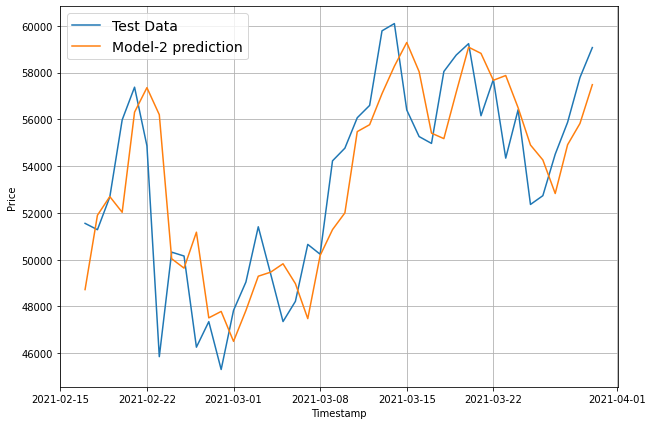

In [ ]:
offset=400
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], format="-", start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_prediction, format="-", start=offset, label="Model-2 prediction")

## Model predictions are lagging the test data trend

## Model 3: Dense (Window =30, Horizon =7)

In [ ]:
HORIZON =7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2200, 2200)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1760, 440, 1760, 440)

In [ ]:
tf.random.set_seed(42)

# Create model (same as model_1 except the different data input and output size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name = "model_3_dense")

# Compile
model_3.compile(loss="MAE", optimizer=tf.keras.optimizers.Adam())

# Fit
model_3.fit(train_windows,
            train_labels,
            batch_size = 128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


INFO:tensorflow:Assets written to: models/model_3_dense/assets


In [ ]:
# Evaluate the model on the test data
model_3.evaluate(x = test_windows, y=test_labels)

14/14 [==============================] - 0s 3ms/step - loss: 1171.5865


1171.5865478515625

In [ ]:
# Load the best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("models/model_3_dense")
model_3.evaluate(x = test_windows, y=test_labels)
"""
  Here the errors are high compared to the other models
  But, since we are predicting the price for 7 days, the
  errors for all the days are added up to give higher value

"""

14/14 [==============================] - 0s 3ms/step - loss: 1161.2301


'\n  Here the errors are high compared to the other models\n  But, since we are predicting the price for 7 days, the\n  errors for all the days are added up to give higher value\n\n'

In [ ]:
# Make predictions with model_3
model_3_prediction = make_prediction(model_3, input_data=test_windows)
model_3_prediction[:2]

<tf.Tensor: shape=(2, 7), dtype=float32, numpy=
array([[7296.3564, 7394.4556, 7439.787 , 7275.1436, 7161.792 , 7393.26  ,
        7215.575 ],
       [7369.169 , 7385.024 , 7437.034 , 7376.398 , 7180.594 , 7426.9663,
        7283.3745]], dtype=float32)>

In [ ]:
model_3_prediction.shape, model_2_prediction.shape

(TensorShape([440, 7]), TensorShape([442]))

In [ ]:
# Make our evaluation function work for larger horizons
# returns error metrics in dictionary form:
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # better to use the numpy version of these too
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mase_(y_true, y_pred)
  
  # Account for different size metrics for longer horizons, we want to
  # reduce metrics to a single value
  if mae.ndim >0:
    # Aggregating the model_3 mae results to a single value just like tensorflow does
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return_dict =  {
                  "mae": mae.numpy(),
                  "mse": mse.numpy(),
                  "rmse": rmse.numpy(),
                  "mape": mape.numpy(),
                  "mase": mase.numpy()
                  }
  return return_dict

In [ ]:
# Evaluate model_3 results
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_3_prediction)
model_3_results

{'mae': 1161.2301,
 'mape': 5.9157295,
 'mase': 0.99872345,
 'mse': 4623193.5,
 'rmse': 1346.3054}

In [ ]:
model_3_prediction

<tf.Tensor: shape=(440, 7), dtype=float32, numpy=
array([[ 7296.3564,  7394.4556,  7439.787 , ...,  7161.792 ,  7393.26  ,
         7215.575 ],
       [ 7369.169 ,  7385.024 ,  7437.034 , ...,  7180.594 ,  7426.9663,
         7283.3745],
       [ 7468.534 ,  7541.931 ,  7518.7905, ...,  7351.747 ,  7527.7417,
         7314.0737],
       ...,
       [57371.    , 59756.73  , 60560.184 , ..., 58080.95  , 59730.83  ,
        60661.54  ],
       [57850.95  , 58096.12  , 59192.805 , ..., 57251.938 , 57038.86  ,
        57387.24  ],
       [56088.543 , 57150.184 , 57424.13  , ..., 54201.004 , 56655.28  ,
        55820.11  ]], dtype=float32)>

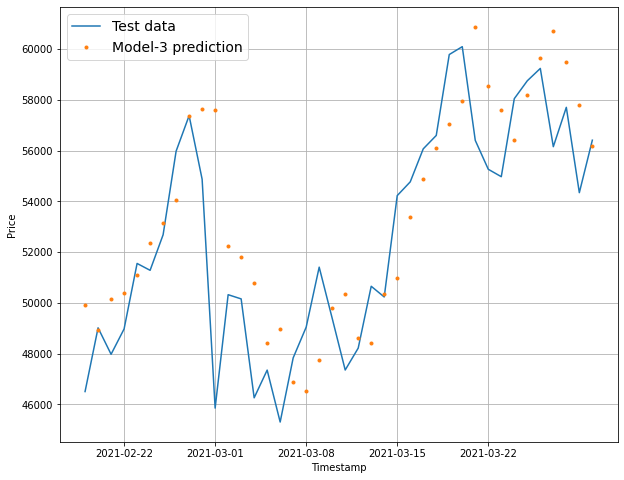

In [ ]:
plt.figure(figsize=(10, 8))
offset = 400
plot_time_series(timesteps=X_test[-len(test_windows):], values = test_labels[:, 0], start=offset, format = "-", label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values= tf.reduce_mean(model_3_prediction, axis = 1), start=offset, label="Model-3 prediction")

### Usually, to visualize we need to reduce the dimension. But, I think I can make more accurate prediction by getting the prediction value of that day from each arrays

## Comparing models

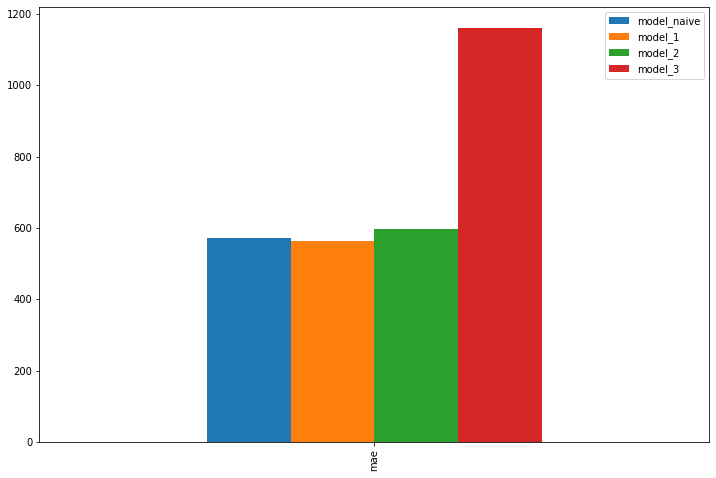

In [ ]:
pd.DataFrame({"model_naive": naive_results["mae"],
              "model_1": model_1_results["mae"],
              "model_2": model_2_results["mae"],
              "model_3": model_3_results["mae"]
              }, index = ["mae"]).plot(figsize=(12,8), kind="bar")

# Naive model gives the good results because the bitcoin dataset is also a auto-correlated data; Timeseries follow significant autocorrelation.

### The models are not CNN, maybe they are Recurrent Neural Networks (RNN)

## Model-4: Conv1D

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7


In [ ]:
prices

array([  754.9 ,   784.19,   809.4 , ..., 55871.93, 57788.15, 59069.29])

In [ ]:
# Create windowed data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2229, 2229)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

Tensorflow conv1D model uses temporal convolution.
We need an input shape of: `(batch_size, timesteps, input_dim)`

In [ ]:
# Current input shape of our data
# which means one sample of training window
# input_dim should be one because we want our model to use 1 week of data to predict 1 horizon at a time
train_windows[0].shape

(7,)

In [ ]:
# Before we pass our data to the conv1D layer, reshaping it:
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=array([754.9 , 784.19, 809.4 , 828.79, 905.  , 919.24, 785.  ])>

In [ ]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for input dim
# Instead of doing tf.expand_dims() directly, we are using lambda layers and the benefit of doing this
# is that we can add this to a model

In [ ]:
# Test out our lambda layer
print(f"Original shape: {x.shape}") # WINDOW_SIZE
print(f"Expanded shape: {expand_dims_layer(x).shape}")
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[754.9 ]
 [784.19]
 [809.4 ]
 [828.79]
 [905.  ]
 [919.24]
 [785.  ]]


In [ ]:
# Adjustments: 1000 epochs, 256 filters (multiples of 8)
# Create model_4


tf.random.set_seed(42)

# Create Conv1D model
model_4 = tf.keras.Sequential([
  # expand_dims_layer
  layers.Lambda(lambda k: tf.expand_dims(k, axis=1)), # firstly adjust the size of our input data
  layers.Conv1D(filters=256, kernel_size=5, strides=1, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows, #if faced data cardinality error, do tf.stack(train_windows) or np.array(train_windows)
            train_labels, 
            batch_size=128, 
            epochs=100, 
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)]
            )

INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


INFO:tensorflow:Assets written to: models/model_4_conv1D/assets


In [ ]:
# train_windows, tf.stack(train_windows)

In [ ]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 256)            9216      
                                                                 
 dense_14 (Dense)            (None, 1, 1)              257       
                                                                 
Total params: 9,473
Trainable params: 9,473
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_2.summary()

Model: "model_2_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 128)               3968      
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_4.evaluate(test_windows, test_labels)

14/14 [==============================] - 0s 4ms/step - loss: 563.0298


563.02978515625

In [ ]:
model_4 = tf.keras.models.load_model("models/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

14/14 [==============================] - 0s 5ms/step - loss: 563.0298


563.02978515625

In [ ]:
# Model predictions
model_4_preds = make_prediction(model_4, test_windows)
model_4_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([7327.7354, 7379.137 , 7467.457 , 7580.3633, 7953.0327],
      dtype=float32)>

In [ ]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_4_preds)
model_4_results

{'mae': 563.02985,
 'mape': 2.752843,
 'mase': 0.99867654,
 'mse': 1327197.2,
 'rmse': 1152.0405}

In [ ]:
naive_results

{'mae': 571.1008,
 'mape': 2.7039125,
 'mase': 0.99867797,
 'mse': 1341613.6,
 'rmse': 1158.2805}

# Model 5: RNN (LSTM)

In [ ]:
# See improving a model section of the bit-predict notebook
tf.random.set_seed(42)

# Make an LSTM model with the functional API
inputs=layers.Input(shape=WINDOW_SIZE)
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# x = layers.LSTM(128, return_sequences=True)(x) # to create more than 1 hidden layer
x = layers.LSTM(128, activation="relu")(x) # default activation function is "tanx"
# One of the way of improving the accuracy of neural network is adding more layers
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)]
            )



Epoch 1/100
13/14 [==========================>...] - ETA: 0s - loss: 3158.7576INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 4s 208ms/step - loss: 3095.0969 - val_loss: 10997.6348
Epoch 2/100
13/14 [==========================>...] - ETA: 0s - loss: 1672.4941INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 182ms/step - loss: 1626.9008 - val_loss: 3911.0088
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 403.4806INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 3s 217ms/step - loss: 403.4806 - val_loss: 1469.0135
Epoch 4/100
14/14 [==============================] - ETA: 0s - loss: 290.4884INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 182ms/step - loss: 290.4884 - val_loss: 1212.0912
Epoch 5/100
13/14 [==========================>...] - ETA: 0s - loss: 230.0776INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 184ms/step - loss: 229.8725 - val_loss: 869.4639
Epoch 6/100
14/14 [==============================] - 0s 12ms/step - loss: 213.5283 - val_loss: 1007.1724
Epoch 7/100
14/14 [==============================] - 0s 11ms/step - loss: 214.5539 - val_loss: 916.8719
Epoch 8/100
14/14 [==============================] - 0s 13ms/step - loss: 210.3837 - val_loss: 929.8438
Epoch 9/100
14/14 [==============================] - 0s 12ms/step - loss: 209.0407 - val_loss: 894.3558
Epoch 10/100
14/14 [==============================] - 0s 12ms/step - loss: 208.1452 - val_loss: 947.1334
Epoch 11/100
14/14 [==============================] - 0s 13ms/step - loss: 207.1694 - val_loss: 873.8170
Epoch 12/100
14/14 [==============================] - 0s 12ms/step - loss: 205.8418 - val_loss: 876.9940
Epoch 13/100
14/14 [==============================] - ETA: 0s - loss: 204.5708INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 188ms/step - loss: 204.5708 - val_loss: 861.7523
Epoch 14/100
14/14 [==============================] - 0s 12ms/step - loss: 203.4718 - val_loss: 884.7316
Epoch 15/100
14/14 [==============================] - 0s 10ms/step - loss: 203.0755 - val_loss: 903.8789
Epoch 16/100
14/14 [==============================] - 0s 13ms/step - loss: 199.9152 - val_loss: 867.3813
Epoch 17/100
14/14 [==============================] - 0s 12ms/step - loss: 198.5207 - val_loss: 868.9608
Epoch 18/100
14/14 [==============================] - 0s 12ms/step - loss: 197.4298 - val_loss: 869.5586
Epoch 19/100
13/14 [==========================>...] - ETA: 0s - loss: 199.8171INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 3s 219ms/step - loss: 196.5982 - val_loss: 847.4629
Epoch 20/100
12/14 [========================>.....] - ETA: 0s - loss: 197.4993INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 3s 191ms/step - loss: 194.8521 - val_loss: 807.9313
Epoch 21/100
14/14 [==============================] - 0s 12ms/step - loss: 193.5974 - val_loss: 833.2915
Epoch 22/100
14/14 [==============================] - 0s 12ms/step - loss: 192.1645 - val_loss: 851.9042
Epoch 23/100
13/14 [==========================>...] - ETA: 0s - loss: 191.5735INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 187ms/step - loss: 190.3922 - val_loss: 806.0175
Epoch 24/100
14/14 [==============================] - ETA: 0s - loss: 191.2002INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 191ms/step - loss: 191.2002 - val_loss: 776.3761
Epoch 25/100
14/14 [==============================] - 0s 13ms/step - loss: 189.2732 - val_loss: 789.4398
Epoch 26/100
14/14 [==============================] - 0s 12ms/step - loss: 185.4485 - val_loss: 826.9142
Epoch 27/100
13/14 [==========================>...] - ETA: 0s - loss: 180.6794INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 186ms/step - loss: 180.7771 - val_loss: 720.4573
Epoch 28/100
13/14 [==========================>...] - ETA: 0s - loss: 174.7659INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 3s 225ms/step - loss: 177.3669 - val_loss: 702.2065
Epoch 29/100
14/14 [==============================] - 0s 13ms/step - loss: 200.3021 - val_loss: 801.3126
Epoch 30/100
14/14 [==============================] - 0s 11ms/step - loss: 185.9404 - val_loss: 766.1492
Epoch 31/100
14/14 [==============================] - 0s 13ms/step - loss: 180.4454 - val_loss: 748.2369
Epoch 32/100
14/14 [==============================] - 0s 12ms/step - loss: 178.5164 - val_loss: 738.5285
Epoch 33/100
14/14 [==============================] - 0s 12ms/step - loss: 176.6198 - val_loss: 817.3339
Epoch 34/100
14/14 [==============================] - 0s 12ms/step - loss: 175.6466 - val_loss: 801.8497
Epoch 35/100
14/14 [==============================] - 0s 12ms/step - loss: 173.6287 - val_loss: 758.5747
Epoch 36/100
14/14 [==============================] - 0s 12ms/step - loss: 171.5962 - val_loss: 772.8608
Epoch 37/100
14/14 [==============================] - 0s 13ms/step 

INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 187ms/step - loss: 168.9907 - val_loss: 686.8839
Epoch 45/100
14/14 [==============================] - ETA: 0s - loss: 169.3746INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 185ms/step - loss: 169.3746 - val_loss: 671.9966
Epoch 46/100
11/14 [======================>.......] - ETA: 0s - loss: 169.6511INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 190ms/step - loss: 162.2892 - val_loss: 667.8841
Epoch 47/100
14/14 [==============================] - 0s 12ms/step - loss: 159.5396 - val_loss: 690.8062
Epoch 48/100
14/14 [==============================] - 0s 12ms/step - loss: 157.0992 - val_loss: 714.4673
Epoch 49/100
14/14 [==============================] - ETA: 0s - loss: 156.7978INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 3s 225ms/step - loss: 156.7978 - val_loss: 655.0980
Epoch 50/100
13/14 [==========================>...] - ETA: 0s - loss: 161.2749INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 189ms/step - loss: 160.2477 - val_loss: 652.5287
Epoch 51/100
14/14 [==============================] - 0s 12ms/step - loss: 155.8842 - val_loss: 653.9545
Epoch 52/100
14/14 [==============================] - ETA: 0s - loss: 154.2570INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 185ms/step - loss: 154.2570 - val_loss: 649.9645
Epoch 53/100
14/14 [==============================] - ETA: 0s - loss: 153.7128INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 184ms/step - loss: 153.7128 - val_loss: 647.3254
Epoch 54/100
13/14 [==========================>...] - ETA: 0s - loss: 153.0165INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 3s 220ms/step - loss: 152.9613 - val_loss: 645.4500
Epoch 55/100
14/14 [==============================] - 0s 13ms/step - loss: 151.5489 - val_loss: 646.0311
Epoch 56/100
14/14 [==============================] - 0s 12ms/step - loss: 150.9307 - val_loss: 665.4196
Epoch 57/100
14/14 [==============================] - 0s 12ms/step - loss: 150.2966 - val_loss: 658.2278
Epoch 58/100
13/14 [==========================>...] - ETA: 0s - loss: 147.0456INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 186ms/step - loss: 150.5427 - val_loss: 635.2477
Epoch 59/100
14/14 [==============================] - 0s 12ms/step - loss: 148.5207 - val_loss: 659.7518
Epoch 60/100
14/14 [==============================] - 0s 13ms/step - loss: 148.5474 - val_loss: 699.8359
Epoch 61/100
14/14 [==============================] - 0s 13ms/step - loss: 148.6339 - val_loss: 640.8013
Epoch 62/100
14/14 [==============================] - 0s 12ms/step - loss: 147.6112 - val_loss: 635.9683
Epoch 63/100
14/14 [==============================] - 0s 12ms/step - loss: 146.9446 - val_loss: 651.4787
Epoch 64/100
12/14 [========================>.....] - ETA: 0s - loss: 148.7262INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 191ms/step - loss: 146.8891 - val_loss: 624.9725
Epoch 65/100
14/14 [==============================] - 0s 12ms/step - loss: 147.9570 - val_loss: 685.9846
Epoch 66/100
14/14 [==============================] - 0s 12ms/step - loss: 145.6583 - val_loss: 641.8666
Epoch 67/100
12/14 [========================>.....] - ETA: 0s - loss: 142.5473INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 187ms/step - loss: 146.0368 - val_loss: 621.8425
Epoch 68/100
14/14 [==============================] - 0s 12ms/step - loss: 146.7642 - val_loss: 652.1619
Epoch 69/100
14/14 [==============================] - 0s 12ms/step - loss: 146.1160 - val_loss: 630.1523
Epoch 70/100
12/14 [========================>.....] - ETA: 0s - loss: 141.1957INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 3s 192ms/step - loss: 147.3013 - val_loss: 616.3434
Epoch 71/100
13/14 [==========================>...] - ETA: 0s - loss: 153.1717INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 3s 233ms/step - loss: 153.1615 - val_loss: 615.7502
Epoch 72/100
14/14 [==============================] - 0s 12ms/step - loss: 155.3015 - val_loss: 673.6431
Epoch 73/100
14/14 [==============================] - 0s 11ms/step - loss: 147.5294 - val_loss: 667.4611
Epoch 74/100
14/14 [==============================] - 0s 12ms/step - loss: 144.3259 - val_loss: 623.6090
Epoch 75/100
12/14 [========================>.....] - ETA: 0s - loss: 143.7967INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 186ms/step - loss: 143.5679 - val_loss: 612.1233
Epoch 76/100
14/14 [==============================] - 0s 11ms/step - loss: 143.5831 - val_loss: 621.3460
Epoch 77/100
14/14 [==============================] - 0s 12ms/step - loss: 142.8463 - val_loss: 619.2382
Epoch 78/100
12/14 [========================>.....] - ETA: 0s - loss: 139.6149INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 3s 192ms/step - loss: 143.3759 - val_loss: 608.2902
Epoch 79/100
14/14 [==============================] - 0s 13ms/step - loss: 143.0520 - val_loss: 614.0178
Epoch 80/100
14/14 [==============================] - 0s 12ms/step - loss: 141.5308 - val_loss: 610.1228
Epoch 81/100
14/14 [==============================] - 0s 12ms/step - loss: 141.8572 - val_loss: 626.2985
Epoch 82/100
14/14 [==============================] - 0s 12ms/step - loss: 141.1483 - val_loss: 618.3405
Epoch 83/100
14/14 [==============================] - 0s 13ms/step - loss: 140.9982 - val_loss: 610.1554
Epoch 84/100
12/14 [========================>.....] - ETA: 0s - loss: 143.4042INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 189ms/step - loss: 141.2170 - val_loss: 605.6880
Epoch 85/100
14/14 [==============================] - 0s 13ms/step - loss: 141.6239 - val_loss: 672.9085
Epoch 86/100
14/14 [==============================] - 0s 12ms/step - loss: 141.4875 - val_loss: 623.3578
Epoch 87/100
11/14 [======================>.......] - ETA: 0s - loss: 143.9005INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 3s 233ms/step - loss: 140.4497 - val_loss: 604.8956
Epoch 88/100
14/14 [==============================] - 0s 12ms/step - loss: 140.4147 - val_loss: 640.0856
Epoch 89/100
11/14 [======================>.......] - ETA: 0s - loss: 148.2961INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 3s 195ms/step - loss: 142.0560 - val_loss: 601.2916
Epoch 90/100
14/14 [==============================] - 0s 13ms/step - loss: 140.8751 - val_loss: 612.8366
Epoch 91/100
14/14 [==============================] - 0s 11ms/step - loss: 139.9382 - val_loss: 604.1487
Epoch 92/100
14/14 [==============================] - 0s 12ms/step - loss: 142.5656 - val_loss: 707.6755
Epoch 93/100
11/14 [======================>.......] - ETA: 0s - loss: 152.1307INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 187ms/step - loss: 146.3548 - val_loss: 599.6319
Epoch 94/100
14/14 [==============================] - 0s 12ms/step - loss: 139.5687 - val_loss: 600.4816
Epoch 95/100
14/14 [==============================] - 0s 12ms/step - loss: 138.4352 - val_loss: 612.8211
Epoch 96/100
12/14 [========================>.....] - ETA: 0s - loss: 132.9806INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 3s 195ms/step - loss: 138.0334 - val_loss: 597.4940
Epoch 97/100
14/14 [==============================] - 0s 12ms/step - loss: 139.9027 - val_loss: 636.2722
Epoch 98/100
13/14 [==========================>...] - ETA: 0s - loss: 137.5749INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 2s 184ms/step - loss: 139.4778 - val_loss: 596.7294
Epoch 99/100
14/14 [==============================] - 0s 11ms/step - loss: 136.9311 - val_loss: 599.2811
Epoch 100/100
14/14 [==============================] - ETA: 0s - loss: 137.3020INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


14/14 [==============================] - 3s 227ms/step - loss: 137.3020 - val_loss: 596.1284


In [ ]:
model_5 = tf.keras.models.load_model("models/model_5_lstm")
model_5.evaluate(test_windows, test_labels)

14/14 [==============================] - 0s 3ms/step - loss: 596.1284


596.12841796875

In [ ]:
# Make predictions with our LSTM model
model_5_preds = make_prediction(model_5, test_windows)


In [ ]:
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_5_preds)
model_5_results

{'mae': 596.12836,
 'mape': 2.9427361,
 'mase': 0.99867654,
 'mse': 1409635.5,
 'rmse': 1187.2808}

## Make a multivariate time-series

In an open system, there are many features that affect the bitcoin price.
In bitcoin halving event, as halving happens, the amount of block reward (the amount of bitcoin we get as a reward after mining) gets decreased.

In [ ]:
# Lets make a multivariate time series
btc_df.tail()

,Price
Timestamp,
2021-03-26,52734.30
2021-03-27,54508.16
2021-03-28,55871.93
2021-03-29,57788.15
2021-03-30,59069.29


In [ ]:
# Adding the bitcoin halving events to our dataset
block_reward_1 = 50 # 3 January 2009- this block reward isn't in our dataset
block_reward_2 = 25 # 8 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-08")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [ ]:
btc_df.index[0] < block_reward_3_datetime

True

In [ ]:
# Adding the specific block reward value
reward = []
for i in range(len(btc_df)):
  timestamp = btc_df.index[i]
  if (timestamp < block_reward_3_datetime and timestamp > block_reward_2_datetime): reward.append(block_reward_2)
  elif (timestamp < block_reward_4_datetime and timestamp > block_reward_3_datetime): reward.append(block_reward_3)
  else: reward.append(block_reward_4) 
)

[6.25, 6.25, 6.25, 6.25, 6.25]

In [ ]:
# len(reward), len(btc_df)
# btc_df["reward"] = reward
btc_blk_df = btc_df.copy()
btc_blk_df["Block_reward"] = reward
btc_blk_df

,Price,Block_reward
Timestamp,,
2014-01-01,754.90,25.00
2014-01-02,784.19,25.00
2014-01-03,809.40,25.00
2014-01-04,828.79,25.00
2014-01-05,905.00,25.00
...,...,...
2021-03-26,52734.30,6.25
2021-03-27,54508.16,6.25
2021-03-28,55871.93,6.25


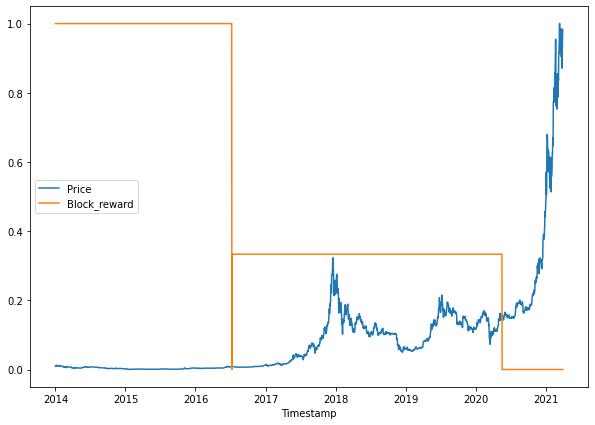

In [ ]:
# Convert the y-scaling of each features to a range of [0,1] to include in the same plot
from sklearn.preprocessing import minmax_scale
scaled_btc_blk_df = pd.DataFrame(minmax_scale(btc_blk_df[["Price", "Block_reward"]]), 
                                 columns = btc_blk_df.columns,
                                 index=btc_blk_df.index
                                 )

scaled_btc_blk_df.plot(figsize = (10,7));